In [0]:
!pip install -q fastai2

In [0]:
import numpy as np
import math
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
from fastai2.data.all import *
from fastai2.tabular.all import *

In [0]:
PI = math.pi
TWOPI = math.pi * 2

get data from figures

In [0]:
filename_left3 = '/content/left_fig3_index012.plt'
df_left3 = pd.read_csv(filename_left3, sep='\s+',header=None, names=["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5", "FLI10", "FLI19", "label"])

filename_left9 = '/content/left_fig9_index012.plt'
df_left9 = pd.read_csv(filename_left9, sep='\s+',header=None, names=["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5", "FLI10", "FLI19", "label"])

filename_right3 = '/content/right_fig3_index012.plt'
df_right3 = pd.read_csv(filename_right3, sep='\s+',header=None, names=["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5", "FLI10", "FLI19", "label"])

filename_right9 = '/content/right_fig9_index012.plt'
df_right9 = pd.read_csv(filename_right9, sep='\s+',header=None, names=["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5", "FLI10", "FLI19", "label"])

In [181]:
df_left3.head()

,sigma,a,FLI1,FLI2,FLI3,FLI5,FLI10,FLI19,label
0,-220.0,42120.0,3.415044,3.783702,3.935543,4.153215,4.470386,4.759377,1.0
1,-216.0,42120.0,3.420663,3.778179,3.920139,4.168725,4.457279,4.746740,1.0
2,-212.0,42120.0,3.426416,3.768147,3.906649,4.166645,4.446171,4.736115,1.0
3,-208.0,42120.0,3.431792,3.755950,3.895131,4.156764,4.437114,4.742599,1.0
4,-204.0,42120.0,3.436535,3.745154,3.885641,4.148871,4.446517,4.738418,1.0


we label chaotic behaviour like 1 and others like 0

In [0]:
for index, item in enumerate(df_left3["label"]):
  if item == 1 or item == 2:
    df_left3["label"][index] = 0 # regular
  elif item == 0:
    df_left3["label"][index] = 1 # chaotic

for index, item in enumerate(df_left9["label"]):
  if item == 1 or item == 2:
    df_left9["label"][index] = 0 # regular
  elif item == 0:
    df_left9["label"][index] = 1 # chaotic

for index, item in enumerate(df_right3["label"]):
  if item == 1 or item == 2:
    df_right3["label"][index] = 0 # regular
  elif item == 0:
    df_right3["label"][index] = 1 # chaotic

for index, item in enumerate(df_right9["label"]):
  if item == 1 or item == 2:
    df_right9["label"][index] = 0 # regular
  elif item == 0:
    df_right9["label"][index] = 1 # chaotic

Text(0.5, 1.0, '1:1 resonance  J2 and J22')

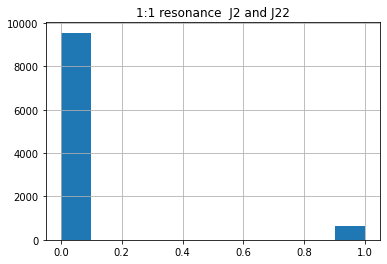

In [183]:
df_left3["label"].hist()
plt.title('1:1 resonance  J2 and J22')

Text(0.5, 1.0, '2:1 resonance  e=0.1')

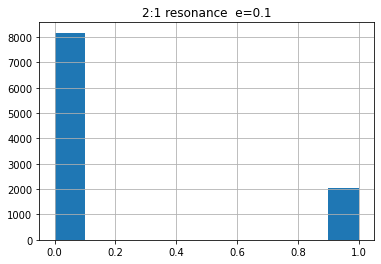

In [184]:
df_left9["label"].hist()
plt.title('2:1 resonance  e=0.1')

Text(0.5, 1.0, '1:1 resonance  n=m=3')

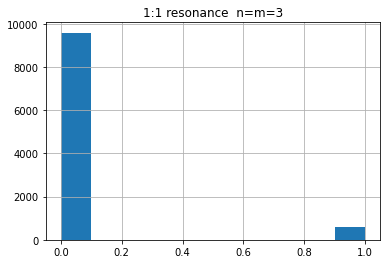

In [185]:
df_right3["label"].hist()
plt.title('1:1 resonance  n=m=3')

Text(0.5, 1.0, '2:1 resonance  e=0.5')

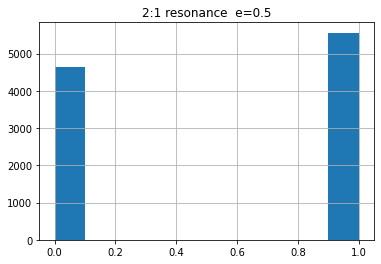

In [186]:
df_right9["label"].hist()
plt.title('2:1 resonance  e=0.5')

Learner for right 9

In [0]:
# cont_names = ["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5", "FLI10"]
# cont_names = ["sigma", "a", "FLI1", "FLI2", "FLI3", "FLI5"]
# cont_names = ["sigma", "a", "FLI1", "FLI2", "FLI3"]
cont_names = ["sigma", "a", "FLI1", "FLI2"]
# cont_names = ["sigma", "a", "FLI1"]
# cont_names = ["sigma", "a"]
dep_var = "label"

In [801]:
splitter = TrainTestSplitter(test_size=0.2, stratify=df_right9['label'])
splits = splitter(range_of(df_right9))
[len(x) for x in splits] # 0 is training, 1 is validation

[8160, 2041]

In [0]:
dls = TabularDataLoaders.from_df(df=df_right9, 
                           procs=[FillMissing(add_col=False), Normalize], 
                           cont_names=cont_names, 
                           y_names=dep_var, 
                           y_block=CategoryBlock(vocab=['0.0','1.0']), 
                           valid_idx=splits[1],
                           bs=64) # Be careful when copying this bs into your own dataset

In [803]:
dls.train.n, dls.valid.n

(8160, 2041)

In [804]:
dls.cont_names

(#4) ['sigma','a','FLI1','FLI2']

In [805]:
dls.valid.show_batch()

,sigma,a,FLI1,FLI2,label
0,180.000000,26586.400391,3.779093,4.116316,0.0
1,75.000000,26557.150391,4.009394,4.484472,1.0
2,-175.000015,26580.099609,3.878648,4.131017,0.0
3,-125.000015,26554.900391,3.731694,4.370694,1.0
4,-80.000000,26572.000000,3.779059,3.788827,1.0
5,260.000000,26561.199219,3.676811,3.676811,0.0
6,139.999985,26556.250000,3.875552,3.883302,0.0
7,-75.000000,26555.349609,3.764816,4.458443,1.0
8,45.000000,26568.849609,3.680456,3.680456,1.0
9,-120.000015,26580.099609,4.015913,4.188138,0.0


# training model

In [0]:
learn = tabular_learner(dls, layers=[100, 50], loss_func=CrossEntropyLossFlat(), metrics=[accuracy])

In [807]:
learn.summary()

TabularModel (Input shape: ['64 x 0', '64 x 4'])
Layer (type)         Output Shape         Param #    Trainable 
BatchNorm1d          64 x 4               8          True      
________________________________________________________________
BatchNorm1d          64 x 4               8          True      
________________________________________________________________
Linear               64 x 100             400        True      
________________________________________________________________
ReLU                 64 x 100             0          False     
________________________________________________________________
BatchNorm1d          64 x 100             200        True      
________________________________________________________________
Linear               64 x 50              5,000      True      
________________________________________________________________
ReLU                 64 x 50              0          False     
_________________________________________________

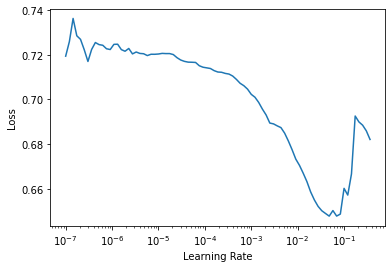

In [808]:
suggested_lrs = learn.lr_find()

In [0]:
lr = suggested_lrs.lr_steep
# lr = suggested_lrs.lr_min

epoch,train_loss,valid_loss,accuracy,time
0,0.495942,0.419992,0.789809,00:01
1,0.452280,0.402768,0.799608,00:01
2,0.427301,0.397018,0.798628,00:01
3,0.403943,0.365181,0.829005,00:01
4,0.383034,0.356974,0.837825,00:01


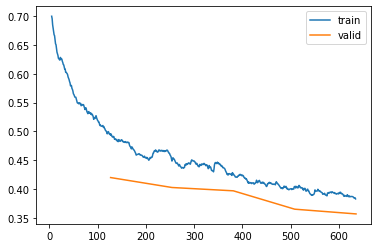

In [810]:
learn.fit_one_cycle(n_epoch=5, lr_max=lr)
learn.recorder.plot_loss()

In [0]:
# learn.show_results()

In [0]:
def show_top_losses(tab_learner, k=None, largest=True):
  interp = Interpretation.from_learner(tab_learner)
  top_losses = interp.top_losses(k, largest)
  to_top_losses = tab_learner.dls.valid.dataset.iloc[top_losses.indices]
  to_top_losses.show()

In [813]:
show_top_losses(learn, k=10, largest=True)

,sigma,a,FLI1,FLI2,label
8223,10.000000,26581.449219,3.775902,4.562516,0.0
2233,-145.000015,26554.900391,3.731517,4.256199,0.0
2720,270.000000,26556.699219,3.722039,4.154030,0.0
8077,290.000000,26580.550781,3.951863,4.685473,0.0
2716,250.000000,26556.699219,3.712585,4.106067,0.0
7367,275.000000,26577.400391,3.929156,4.643074,0.0
7314,10.000000,26577.400391,3.690053,3.873088,0.0
7115,25.000000,26576.500000,3.659233,3.750908,0.0
2249,-65.000000,26554.900391,3.789002,4.563735,0.0
7018,45.000000,26576.050781,3.647634,3.788872,0.0


In [814]:
show_top_losses(learn, k=10, largest=False)

,sigma,a,FLI1,FLI2,label
10087,240.000000,26589.550781,3.855477,4.159001,0.0
10084,225.000000,26589.550781,3.827646,4.129758,0.0
9985,235.000000,26589.099609,3.851391,4.158267,0.0
9982,220.000000,26589.099609,3.823235,4.129180,0.0
10080,205.000000,26589.550781,3.799252,4.095995,0.0
9880,215.000000,26588.650391,3.818676,4.128716,0.0
10177,185.000000,26590.000000,3.783663,4.084904,0.0
10176,180.000000,26590.000000,3.781682,4.085180,0.0
10103,-184.999985,26590.000000,3.780295,4.085943,0.0
9577,215.000000,26587.300781,3.832926,4.155499,0.0


# SHAP

In [0]:
!pip install -q fastshap

In [0]:
from fastshap.interp import *

In [817]:
exp = ShapInterpretation(learn)

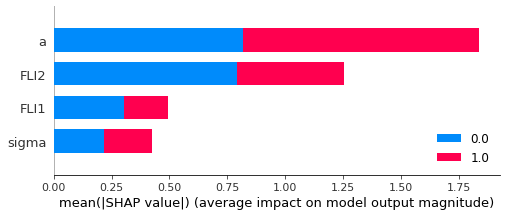

In [818]:
exp.summary_plot()

Classification model detected, displaying score for the class 0.0.
(use `class_id` to specify another class)


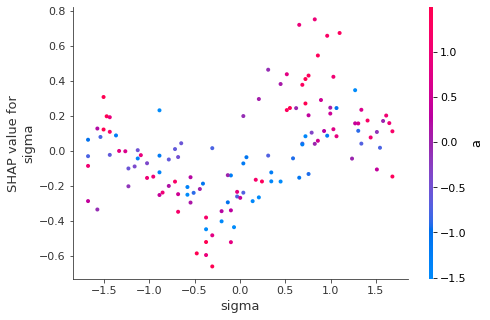

In [819]:
exp.dependence_plot('sigma', class_id=0, interaction_index='a')

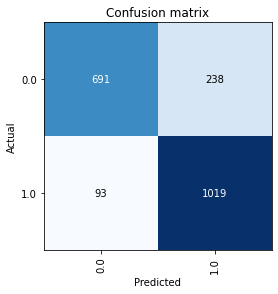

In [820]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

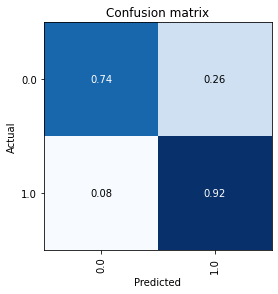

In [821]:
interp.plot_confusion_matrix(normalize=True)

In [0]:
recall = Recall(pos_label=1)
f2 = FBeta(beta=2, pos_label=1)

In [823]:
learn.metrics = [accuracy, recall, f2]
[x.name for x in learn.metrics]

['accuracy', 'recall_score', 'fbeta_score']

In [824]:
res = learn.validate()
print(f'accuracy={res[1]}, recall={res[2]}, f2={res[3]}')

accuracy=0.8378245830535889, recall=0.9163669064748201, f2=0.8930762489044698
